# Translation model from COCO -> MPII


In [141]:
import torch
import numpy as np
import torch.nn as nn
import copy
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import json

In [142]:
def describe(data):
  # Find maximum value
  max_val = np.max(data)

  # Find minimum value
  min_val = np.min(data)

  # Find 25th percentile
  percentile_25 = np.percentile(data, 25)

  # Find 75th percentile
  percentile_75 = np.percentile(data, 75)

  print("Maximum:", max_val)
  print("Minimum:", min_val)
  print("25th percentile:", percentile_25)
  print("75th percentile:", percentile_75)

In [143]:


ROOT_FOLDER = "/datagrid/personal/baljibil"
# ground truth
with open(ROOT_FOLDER + '/repos/scripts/data/mpii_train_gt.json', 'r') as f:
    annot_truth = json.load(f)
# prediction
with open(ROOT_FOLDER + '/repos/scripts/data/coco_pred_mpii.json', 'r') as f:
    annot_pred_coco = json.load(f)

# with open(ROOT_FOLDER + '/repos/scripts/mpii_pred_on_mpii/pred.json', 'r') as f:
#     annot_pred_mpii = json.load(f)



In [144]:
X = list()
y = list()
box_scale = list()
box_center = list()
index2orig = list()

print("len: " , len(annot_truth))
for i in range(len(annot_truth)):
  skip = False
  for joint_vis in annot_truth[i]['joints_vis']:
    if joint_vis == 0:
      skip = True
      break
  if skip:
    continue
  index2orig.append(i)
  X.append(annot_pred_coco['annotations'][i]['joints'])
  y.append(annot_truth[i]['joints'])
  box_scale.append(annot_truth[i]['scale'])
  box_center.append(annot_truth[i]['center'])
X = np.array(X)
y = np.array(y)
box_scale = np.array(box_scale)
box_center = np.array(box_center)
print("X shape: ", X.shape)
print("y shape:", y.shape)
print("box scale:", box_scale.shape)
print("box center:", box_center.shape)

len:  22246
X shape:  (14975, 17, 2)
y shape: (14975, 16, 2)
box scale: (14975,)
box center: (14975, 2)


## Normalize the dataset
- First by scale value of the bounding box
- Then either 0-1 normalization

In [145]:
def center_and_scale(data):
    return (data - box_center[:,np.newaxis,:]) / box_scale[:, np.newaxis, np.newaxis]
def uncenter_and_unscale(data):
    return data * box_scale[:, np.newaxis, np.newaxis] + box_center[:,np.newaxis,:]
def normalize(data):
    data = center_and_scale(data)
    min_val = -150
    max_val = 150
    return (data - (min_val)) / (max_val - min_val)
def unnormalize(data):
    min_val = -150
    max_val = 150
    data = data * (max_val - min_val) + min_val
  
    return uncenter_and_unscale(data)
X_centered = center_and_scale(X)
y_centered = center_and_scale(y)
X_normalized = normalize(X)
y_normalized = normalize(y)



In [146]:
print((X == uncenter_and_unscale(center_and_scale(X))).sum() != 0)
print((X == unnormalize(normalize(X))).sum() != 0)


True
True


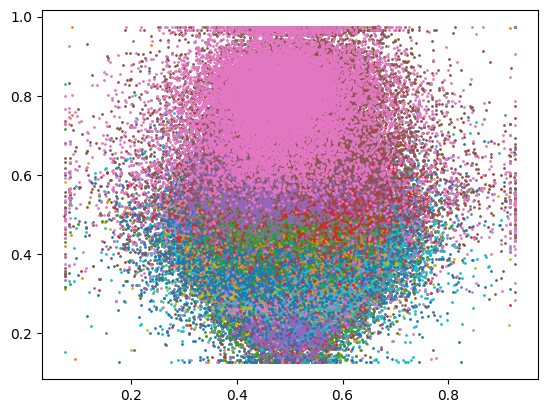

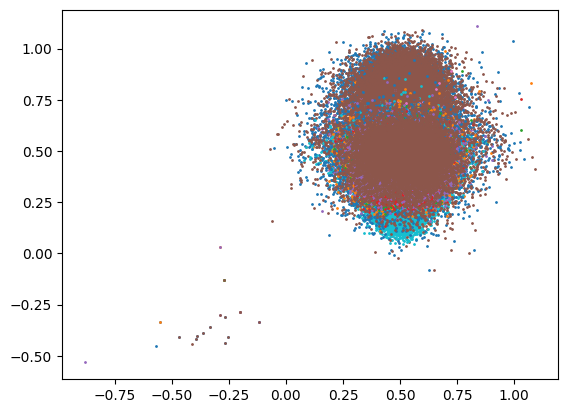

In [147]:
for i in range(17):
  plt.scatter(X_normalized[:, i, 0],X_normalized[:, i, 1], s=1)
plt.show()

for i in range(16):
  plt.scatter(y_normalized[:, i, 0],y_normalized[:, i, 1], s=1)
plt.show()

### Display outliers in normalized env

In [148]:
outlier_index = np.argmin(y_normalized)
index = np.unravel_index(outlier_index, y_normalized.shape)
print(index)
print(y[ index[0] ])
print(y_normalized[index[0]])
print("Box center")
print(box_center[index[0]])
print("Box scale")
print(box_scale[index[0]])

print("Joint vis")

print(annot_truth[index2orig[index[0]]]['joints_vis'])
print(len(annot_truth[index2orig[index[0]]]['joints_vis']))


(9630, 14, 0)
[[1241.  533.]
 [1245.  490.]
 [1249.  424.]
 [1276.  420.]
 [1277.  488.]
 [1278.  532.]
 [1263.  422.]
 [1249.  354.]
 [1242.  333.]
 [1229.  297.]
 [1239.  404.]
 [1241.  377.]
 [1223.  365.]
 [1274.  343.]
 [ 736.   15.]
 [1276.  390.]]
[[ 0.57810805  0.96575541]
 [ 0.58967961  0.84136111]
 [ 0.60125118  0.65043032]
 [ 0.67935922  0.63885875]
 [ 0.68225212  0.83557532]
 [ 0.68514501  0.96286252]
 [ 0.64175165  0.64464454]
 [ 0.60125118  0.44792797]
 [ 0.58100094  0.38717726]
 [ 0.54339336  0.2830332 ]
 [ 0.57232227  0.5925725 ]
 [ 0.57810805  0.51446445]
 [ 0.52603602  0.47974976]
 [ 0.67357344  0.41610617]
 [-0.88280176 -0.53276199]
 [ 0.67935922  0.55207203]]
Box center
[1214.  372.]
Box scale
1.15225
Joint vis
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
16


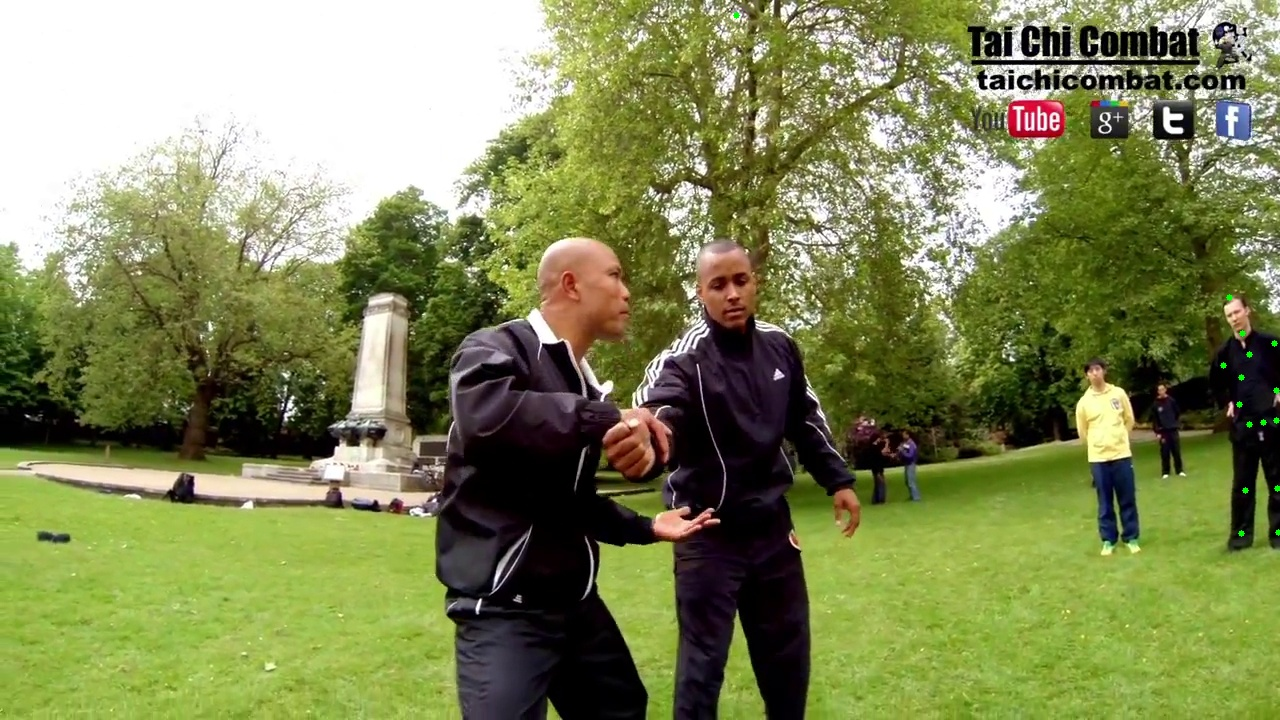

In [149]:
ROOT_FOLDER = "/datagrid/personal/baljibil"

# from utils import display_kp_image
from IPython.display import Image, display
import cv2

def display_kp_image(im_path, keypoints):

  image = cv2.imread(im_path)

  for kp in keypoints:
      x, y = int(kp[0]), int(kp[1])
      cv2.circle(image, (x, y), 3, (0, 255, 0), -1)

  # Split the image horizontally
#   image1 = image[:, :image.shape[1]//2]
#   image2 = image[:, image.shape[1]//2:]

  # Display the annotated images side by side
  cv2.imwrite(f'tm_results/image_test0.jpg', image)

  display(Image(filename=f'tm_results/image_test0.jpg'))

display_kp_image(ROOT_FOLDER+'/data/MPII_COCO/images/'+annot_truth[index2orig[index[0]]]['image'],
                annot_truth[index2orig[index[0]]]['joints']
                 )

## Split train, val, test

In [150]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print("Train instance: ", X_train.shape[0])
print("Val instance: ", X_val.shape[0])
print("Test instance: ", X_test.shape[0])

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)


Train instance:  7861
Val instance:  2621
Test instance:  4493
torch.Size([7861, 17, 2])
torch.Size([7861, 16, 2])
torch.Size([2621, 17, 2])
torch.Size([2621, 16, 2])


# PCK Accuracy implementation

In [151]:
# Given prediction and ground truth with of Nx16x2, where N is sample num return PCKh score.
def calculatePCKh(predict, gt):
    if torch.is_tensor(predict) and torch.is_tensor(gt):
        distances = torch.norm((gt - predict), dim=-1)
        head_length = torch.norm((gt[:, 8] - gt[:, 9]), dim=-1) * 0.5
        correct_classified = distances < head_length[:, None]
        correct_classified = torch.sum(correct_classified, dim=-1)
        total_keypoints = gt.shape[0] * gt.shape[1]
        percentage = correct_classified.sum() / total_keypoints
    else:
        distances = np.linalg.norm((gt - predict), axis=-1)
        head_length = np.linalg.norm((gt[:, 8] - gt[:, 9]), axis=-1) * 0.5
        correct_classified = distances < head_length[:, np.newaxis]
        correct_classified = np.sum(correct_classified, axis=-1)
        total_keypoints = gt.shape[0] * gt.shape[1]
        percentage = correct_classified.sum() / total_keypoints
    return percentage


calculatePCKh(y_normalized, y_normalized)

1.0

## Define baseline accuracy

In [152]:
# Fake X identity base/ Direct COCO->MPII
mapping =  {0:16, 1:14, 5: 15, 4: 13, 2:12, 3:11, 15: 9, 14:7, 13: 5, 10:10, 11:8, 12:6}
# Mergeable points merge
X_mpii_identity = np.ones_like(y_centered)
for mpii_key, coco_key in mapping.items():
  X_mpii_identity[:,mpii_key] = X_centered[:,coco_key]
# pelvis (To define baseline, pelvis is almost in the middle of left and right hip)
X_mpii_identity[:,6] = (X_mpii_identity[:,2]+X_mpii_identity[:,3])/2
# thorax (To define baseline, thorax is almost in the middle of left and right shoulder)
X_mpii_identity[:,7] = (X_mpii_identity[:,12]+X_mpii_identity[:,13])/2
X_mpii_identity[:,8] = (X_mpii_identity[:,7]+X_centered[:,0])/2
X_mpii_identity[:,9] = (X_centered[:, 1] + X_centered[:, 2] ) / 2

print(calculatePCKh(X_mpii_identity, y_centered))


0.8973873121869783


In [153]:
# Create a DataLoader for training and validation data
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TranslatorNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.hidden1 = nn.Linear(17 * 2, 64)
        self.act1 = nn.Tanh()
        self.hidden2 = nn.Linear(64, 32)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(32, 16*2)
        self.act_output = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act_output(self.output(x))
        return x.view(-1, 16, 2)


def init_model():
# Instantiate the model, loss function, and optimizer
    return TranslatorNN().to(device)
# print(X_train.shape)

def train_model(model, lr=0.01, max_epoch=100, logs=[]):
    criterion = nn.L1Loss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    best_epoch = 0
    best_val_loss = 10000000
    best_model = None
    best_accuracy = 0
    # Training loop
    for epoch in range(max_epoch):
        if epoch == 0:
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item() * inputs.size(0)
            val_epoch_loss = val_loss / len(val_dataset)
        
            print(f"Epoch [{epoch}/{max_epoch}], Val Loss: {val_epoch_loss:.6f}")
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_dataset)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        val_size = 0
        accuracy = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                val_size += inputs.size(0)
                accuracy += (calculatePCKh(outputs, targets))
        val_epoch_loss = val_loss / len(val_dataset)
        # Cuz batch size is 1?
        accuracy = accuracy / (len(val_dataset) / val_loader.batch_size)
        # For 16 keypoints
        if accuracy > best_accuracy:
            best_model = copy.deepcopy(model)
            best_epoch = epoch
            best_val_loss = val_loss
            best_accuracy = accuracy
        logs.append((epoch+1,epoch_loss, val_epoch_loss, accuracy))
        if (epoch+1) % 10 == 1:
            print(f"Epoch [{epoch+1}/{max_epoch}], Train Loss: {epoch_loss:.6f}, Val Loss: {val_epoch_loss:.6f} Accuracy: {accuracy * 100:.2f}%")
    # model at best epoch
    return best_epoch, best_model, best_val_loss, best_accuracy



In [156]:
# learning_rates = [1, 0.1, 0.15, 0.5, 0.01, 0.03, 0.001, 0.003, 0.0001]
learning_rates = [0.5, 1, 0.6, 0.7, 0.4]

# batch_size = [1,4,8,16,32,64]
epoch_max = [200]
param_comb = [{'lr':x, 'epoch':y} for x in learning_rates for y in epoch_max]
print(len(param_comb),param_comb)

best_model = None
best_loss = None
best_params = None
best_accuracy = 0
best_model_logs = []
for param in param_comb:
  print(f'Training for param: {param}')
  lr = param['lr']
  epoch = param['epoch']
  results_logs = []

  t_epoch, t_model, t_loss, t_accuracy = train_model(init_model(),lr=lr,max_epoch=epoch,logs=results_logs)
  print(f'{param} -> {t_accuracy:.2f}')

  if t_accuracy > best_accuracy:
    best_model = copy.deepcopy(t_model)
    best_model_logs = copy.deepcopy(results_logs)
    best_loss = t_loss
    best_epoch = t_epoch
    best_params = param
    best_accuracy = t_accuracy
  



5 [{'lr': 0.5, 'epoch': 200}, {'lr': 1, 'epoch': 200}, {'lr': 0.6, 'epoch': 200}, {'lr': 0.7, 'epoch': 200}, {'lr': 0.4, 'epoch': 200}]
Training for param: {'lr': 0.5, 'epoch': 200}
Epoch [0/200], Val Loss: 0.102356
Epoch [1/200], Train Loss: 0.062709, Val Loss: 0.056679 Accuracy: 34.12%
Epoch [11/200], Train Loss: 0.037712, Val Loss: 0.036722 Accuracy: 59.84%
Epoch [21/200], Train Loss: 0.030300, Val Loss: 0.029399 Accuracy: 72.74%
Epoch [31/200], Train Loss: 0.026266, Val Loss: 0.027094 Accuracy: 77.62%
Epoch [41/200], Train Loss: 0.024416, Val Loss: 0.025543 Accuracy: 81.20%
Epoch [51/200], Train Loss: 0.023099, Val Loss: 0.022051 Accuracy: 85.85%
Epoch [61/200], Train Loss: 0.022095, Val Loss: 0.021680 Accuracy: 86.38%
Epoch [71/200], Train Loss: 0.021619, Val Loss: 0.021344 Accuracy: 87.24%
Epoch [81/200], Train Loss: 0.021029, Val Loss: 0.020467 Accuracy: 88.36%
Epoch [91/200], Train Loss: 0.020576, Val Loss: 0.021384 Accuracy: 87.70%
Epoch [101/200], Train Loss: 0.020186, Val Lo

In [ ]:
# Training and validation statistics
epochs = [val[0] for val in best_model_logs]
train_losses = [val[1] for val in best_model_logs]
val_losses = [val[2] for val in best_model_logs]
accuracies = [val[3] for val in best_model_logs]

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, label='Accuracy', color='green', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

torch.Size([14975, 16, 2])
0.8501293823038397


## Display some images from translation model

In [ ]:
import cv2
from IPython.display import Image, display

10465 027253117.jpg
[422.0, 375.0]
5.933827
[[-1.0, -1.0], [-1.0, -1.0], [348.0, 599.0], [404.0, 592.0], [-1.0, -1.0], [-1.0, -1.0], [376.0, 596.0], [415.0, 293.0], [429.3995, 257.9704], [504.6005, 75.0296], [431.0, 545.0], [262.0, 479.0], [301.0, 280.0], [528.0, 305.0], [580.0, 433.0], [663.0, 512.0]]
(17, 2)
torch.Size([1, 17, 2])
PCKh:  tensor(0.2500)
(16, 2)


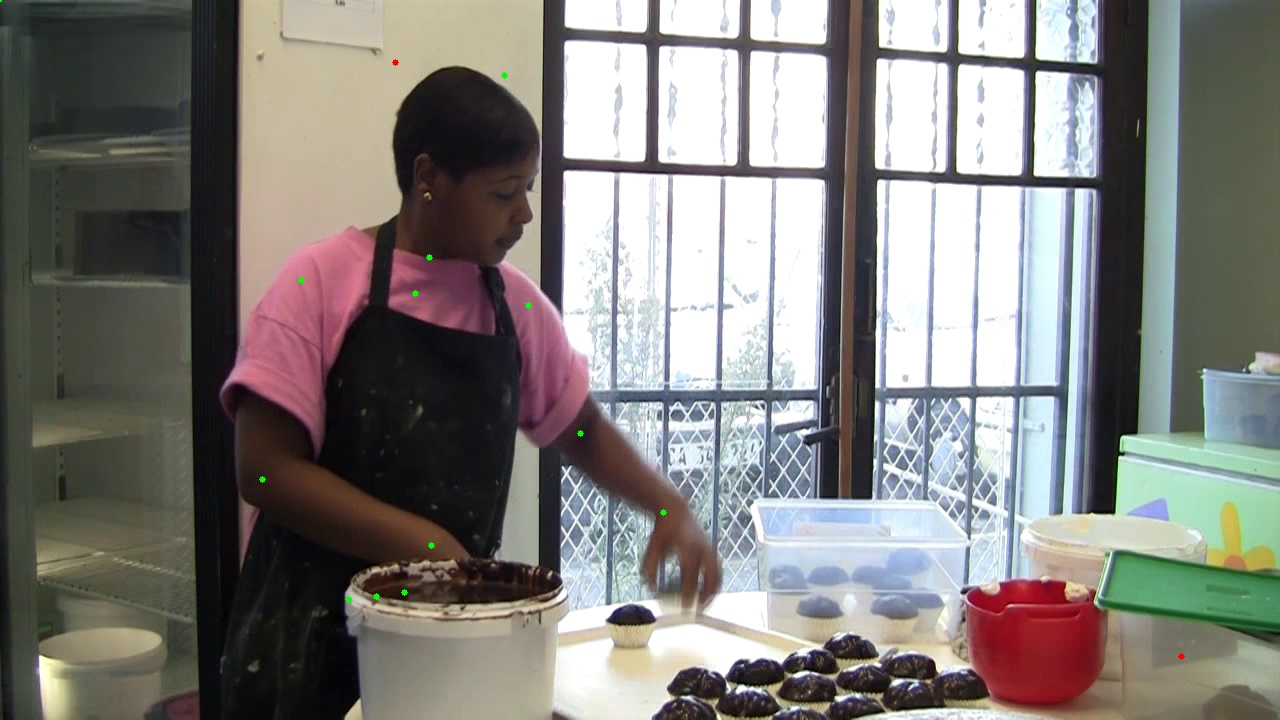

11591 087906200.jpg
[493.0, 317.0]
5.058936
[[-1.0, -1.0], [-1.0, -1.0], [464.0, 553.0], [557.0, 551.0], [-1.0, -1.0], [-1.0, -1.0], [511.0, 552.0], [508.0, 256.0], [524.6295, 226.4684], [607.3705, 79.5316], [367.0, 582.0], [353.0, 425.0], [402.0, 264.0], [613.0, 247.0], [743.0, 276.0], [824.0, 195.0]]
(17, 2)
torch.Size([1, 17, 2])
PCKh:  tensor(0.2500)
(16, 2)


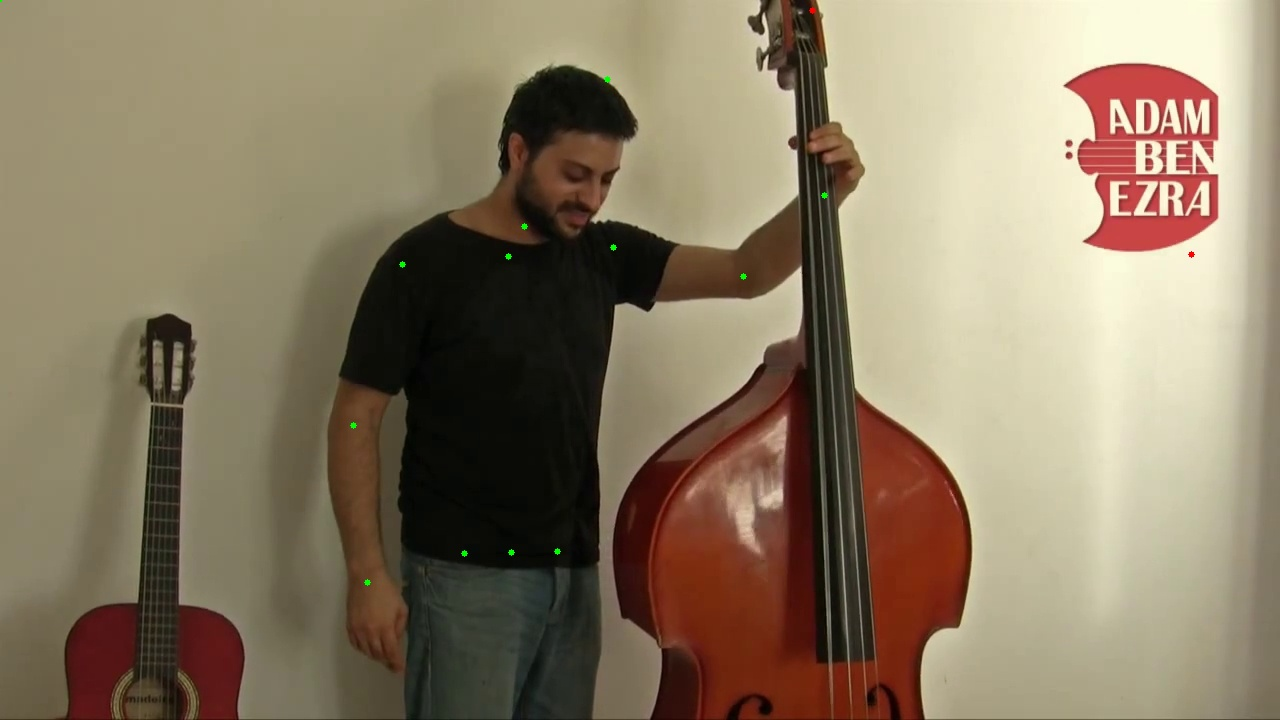

961 068325876.jpg
[479.0, 270.0]
3.696701
[[-1.0, -1.0], [-1.0, -1.0], [391.0, 313.0], [473.0, 334.0], [-1.0, -1.0], [-1.0, -1.0], [432.0, 324.0], [498.0, 175.0], [490.1573, 181.1967], [586.8427, 104.8033], [402.0, 303.0], [346.0, 205.0], [445.0, 135.0], [551.0, 215.0], [562.0, 298.0], [631.0, 347.0]]
(17, 2)
torch.Size([1, 17, 2])
PCKh:  tensor(0.2500)
(16, 2)


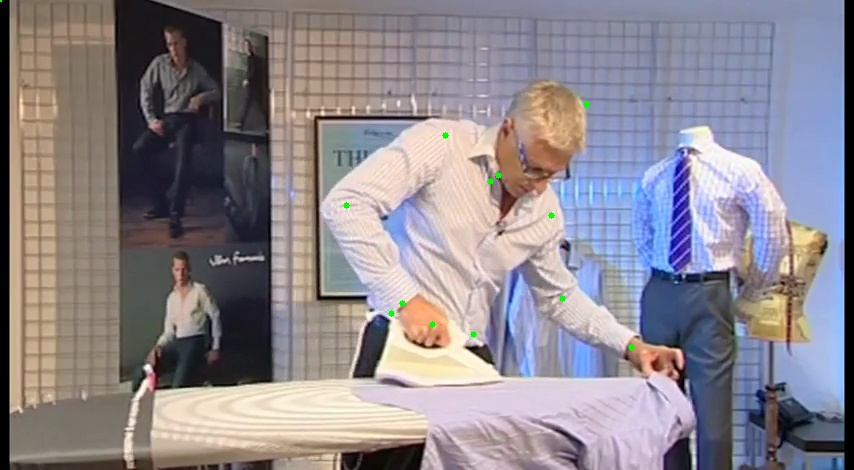

21512 010693606.jpg
[887.0, 450.0]
4.216698
[[701.0, 727.0], [771.0, 558.0], [752.0, 399.0], [812.0, 402.0], [884.0, 534.0], [833.0, 695.0], [782.0, 401.0], [883.0, 245.0], [893.0798, 236.5739], [1000.9202, 146.4261], [804.0, 482.0], [793.0, 367.0], [852.0, 251.0], [914.0, 238.0], [903.0, 348.0], [900.0, 423.0]]
(17, 2)
torch.Size([1, 17, 2])
PCKh:  tensor(0.)
(16, 2)


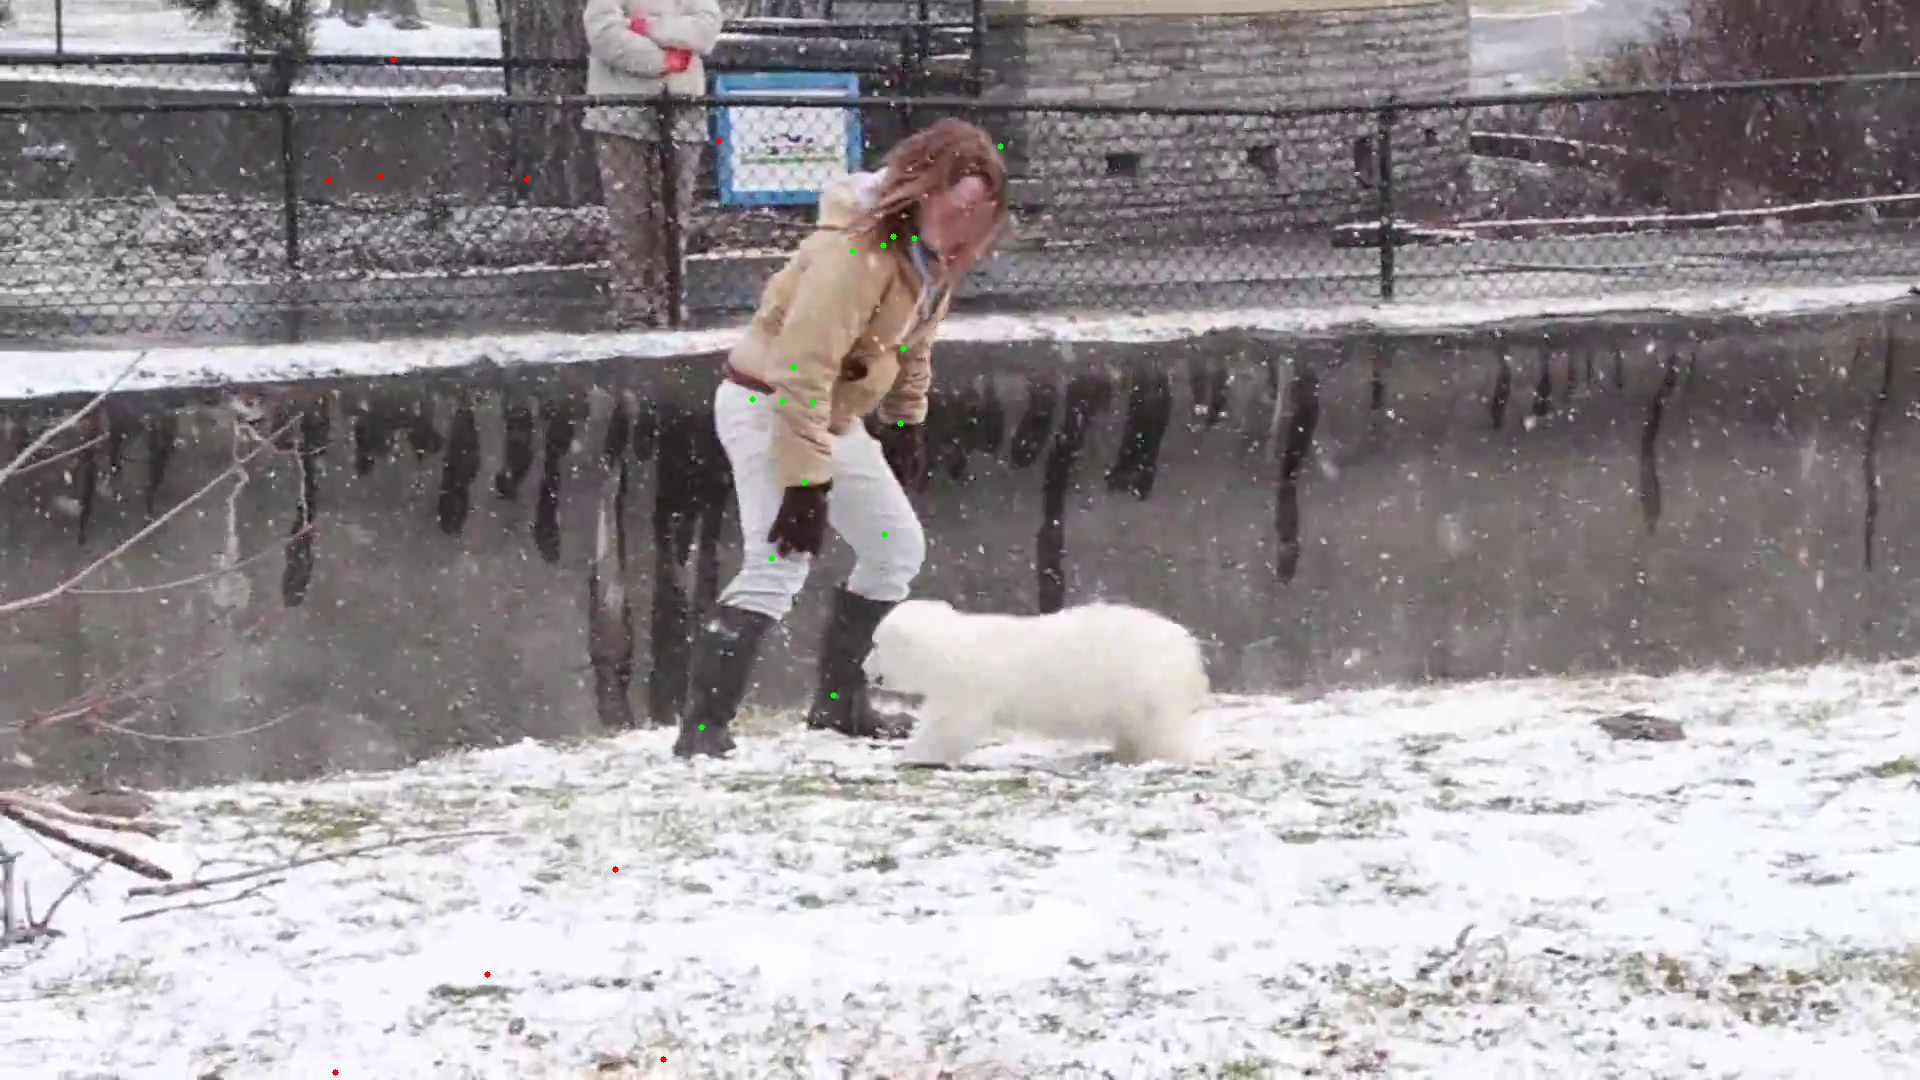

7490 094356522.jpg
[1041.0, 340.0]
1.627228
[[1043.0, 454.0], [988.0, 426.0], [1033.0, 352.0], [1063.0, 354.0], [1014.0, 418.0], [1037.0, 500.0], [1048.0, 353.0], [1022.0, 308.0], [1020.4464, 302.9302], [1004.5536, 251.0698], [937.0, 317.0], [971.0, 308.0], [1006.0, 288.0], [1037.0, 328.0], [1042.0, 372.0], [1006.0, 383.0]]
(17, 2)
torch.Size([1, 17, 2])
PCKh:  tensor(0.)
(16, 2)


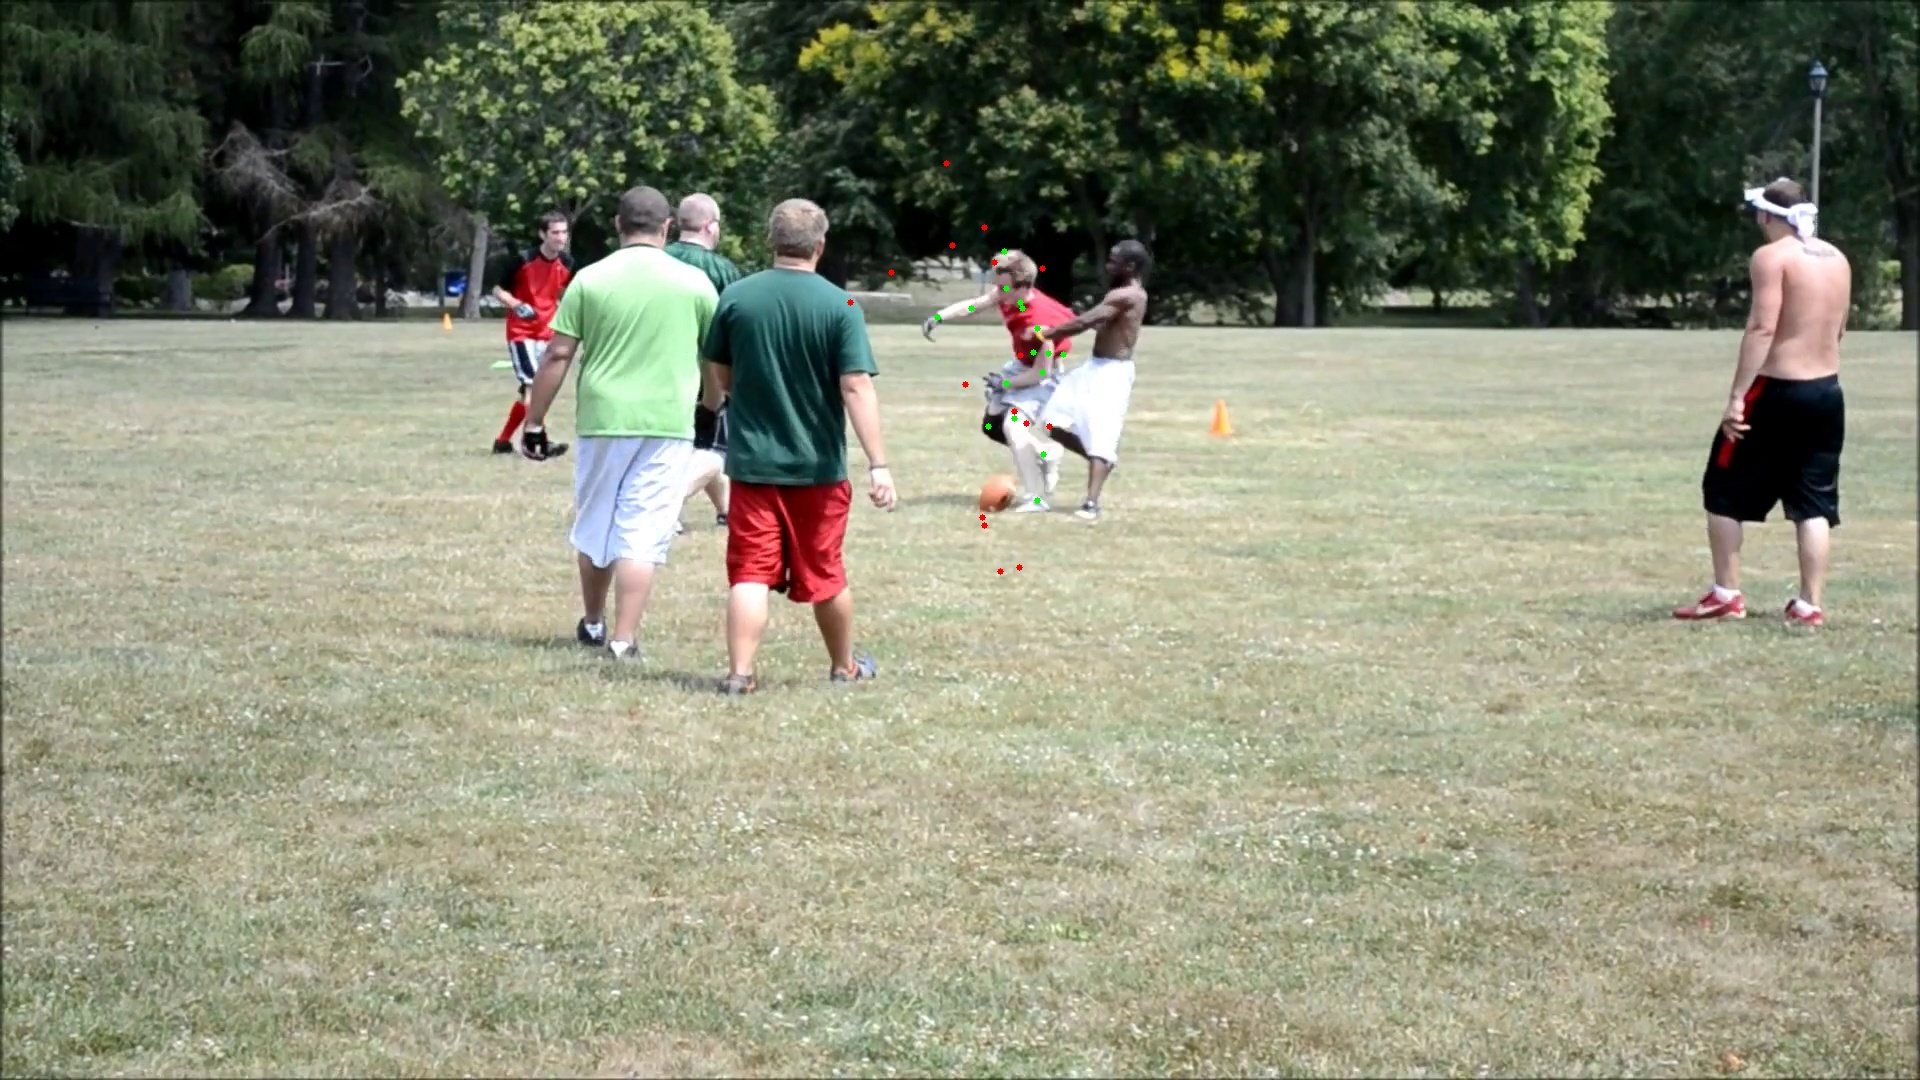

20559 091662337.jpg
[638.0, 308.0]
2.070826
[[581.0, 437.0], [573.0, 343.0], [601.0, 285.0], [634.0, 290.0], [666.0, 346.0], [692.0, 431.0], [618.0, 288.0], [627.0, 267.0], [597.6575, 264.0658], [666.3425, 270.9342], [553.0, 298.0], [535.0, 277.0], [596.0, 246.0], [658.0, 288.0], [673.0, 344.0], [666.0, 392.0]]
(17, 2)
torch.Size([1, 17, 2])
PCKh:  tensor(0.)
(16, 2)


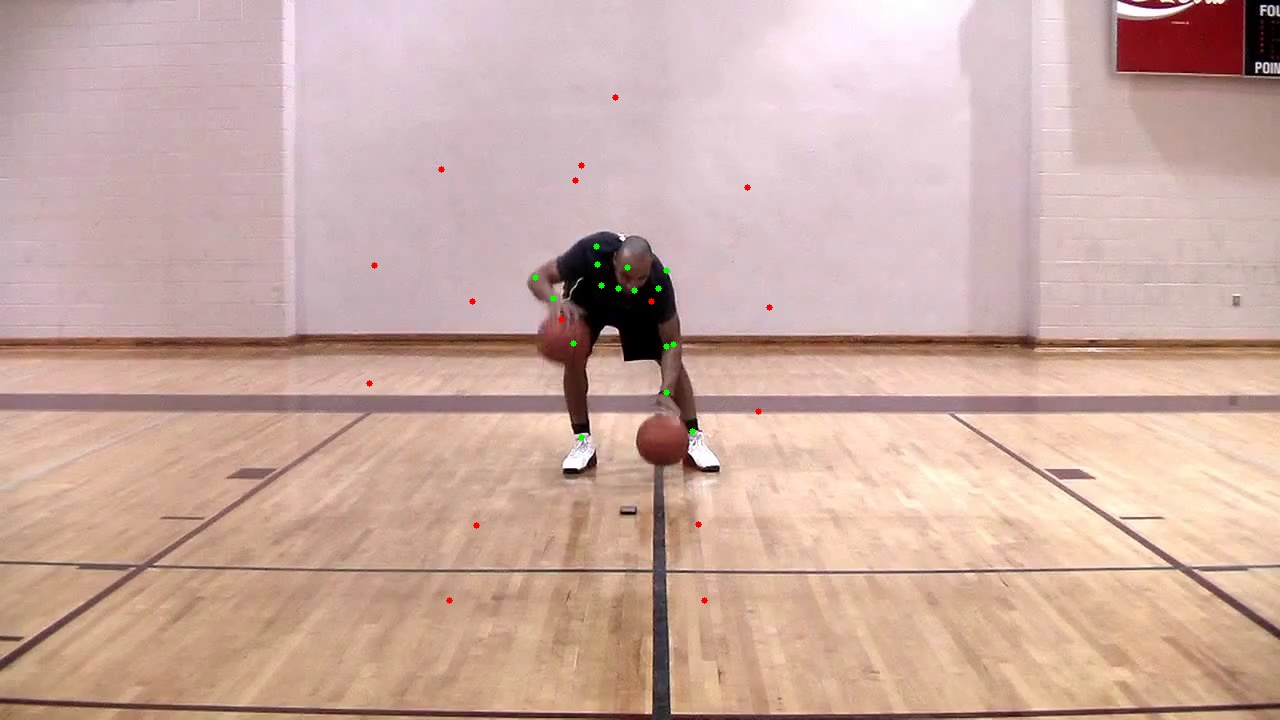

21375 045216075.jpg
[335.0, 677.0]
5.233981
[[198.0, 819.0], [292.0, 667.0], [90.0, 617.0], [68.0, 612.0], [205.0, 763.0], [225.0, 937.0], [79.0, 615.0], [256.0, 508.0], [270.5107, 493.8662], [395.4893, 372.1338], [441.0, 689.0], [362.0, 619.0], [280.0, 540.0], [232.0, 475.0], [319.0, 581.0], [408.0, 653.0]]
(17, 2)
torch.Size([1, 17, 2])
PCKh:  tensor(0.)
(16, 2)


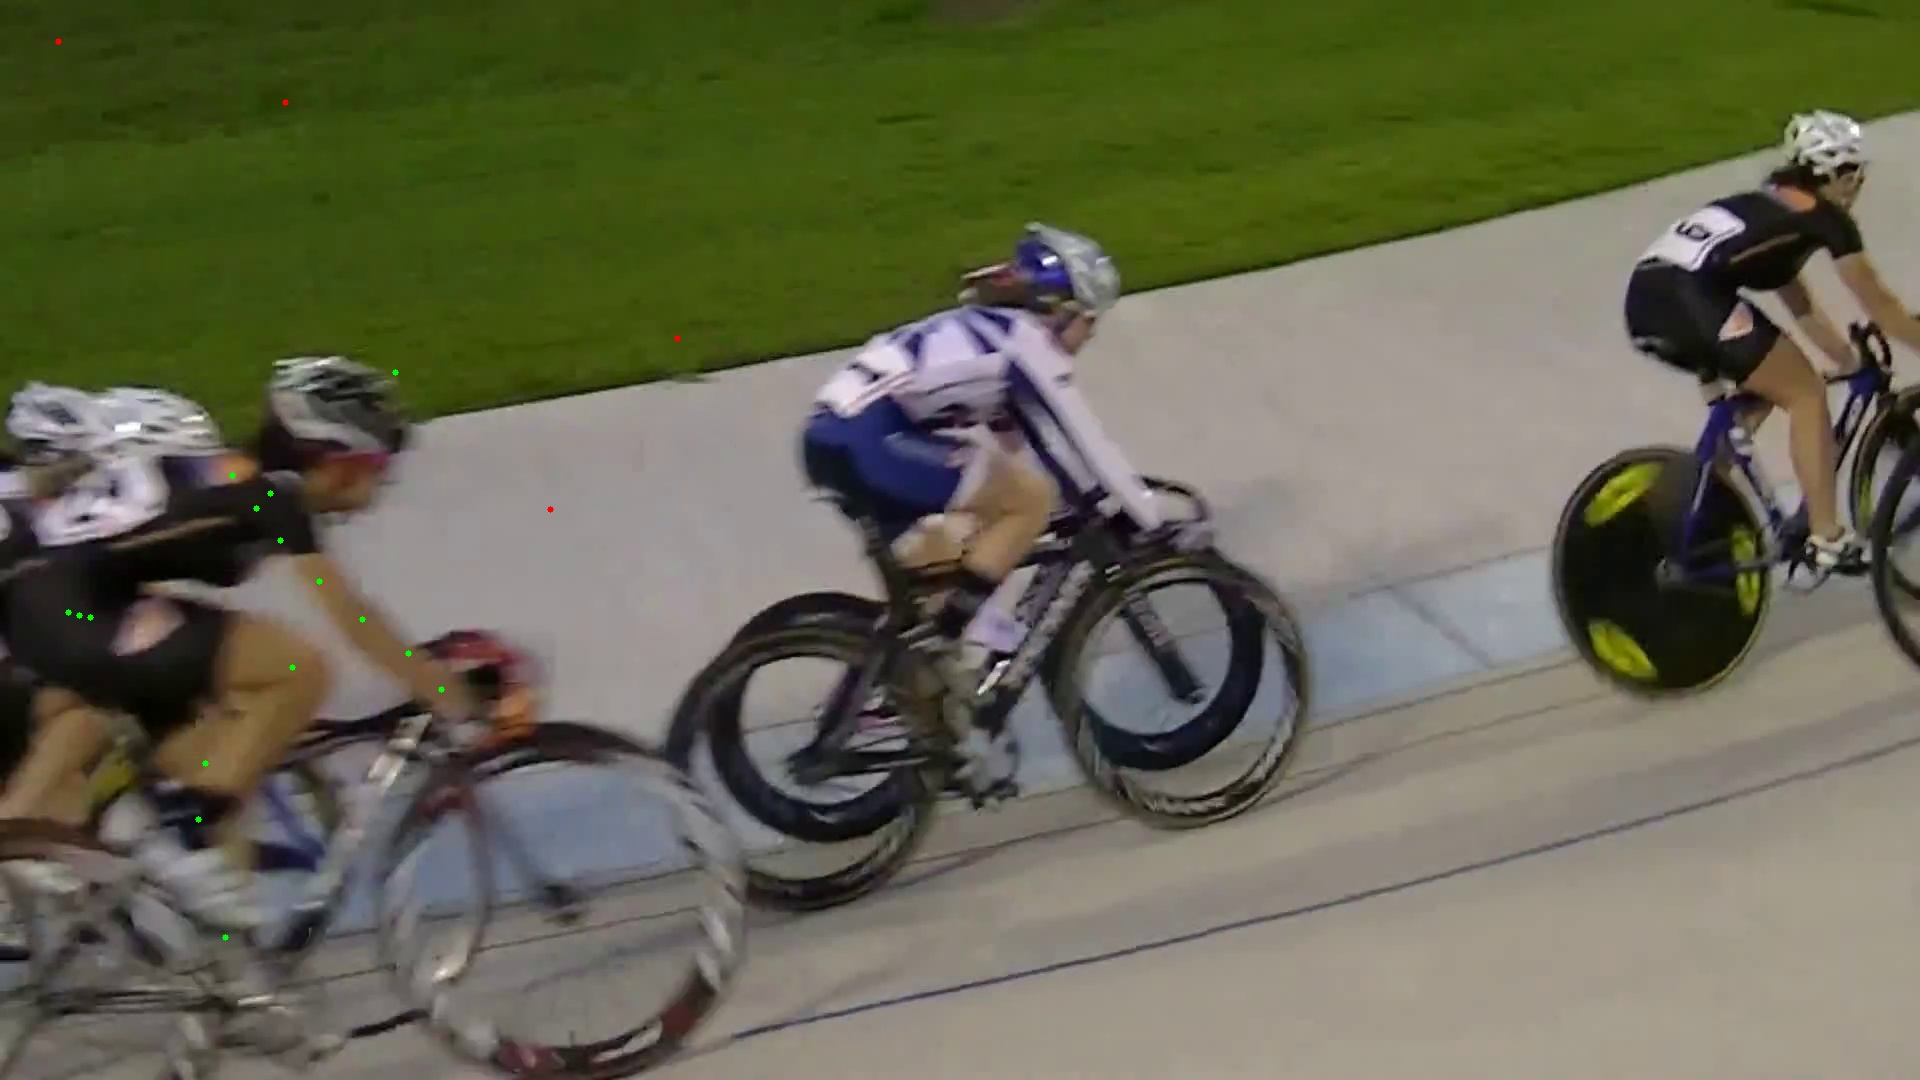

4678 028972798.jpg
[298.0, 189.0]
2.728833
[[-1.0, -1.0], [386.0, 412.0], [384.0, 285.0], [417.0, 290.0], [404.0, 432.0], [-1.0, -1.0], [401.0, 288.0], [329.0, 146.0], [314.1094, 115.7933], [273.8906, 34.2067], [176.0, 109.0], [240.0, 143.0], [312.0, 134.0], [346.0, 158.0], [371.0, 262.0], [316.0, 312.0]]
(17, 2)
torch.Size([1, 17, 2])
PCKh:  tensor(0.1250)
(16, 2)


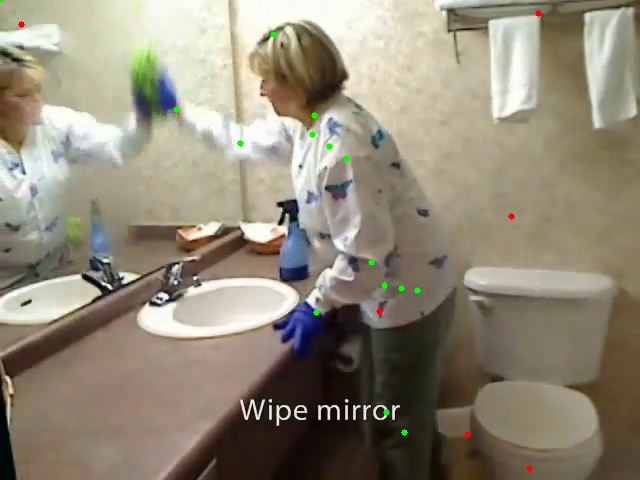

12303 008947838.jpg
[316.0, 355.0]
2.544
[[297.0, 599.0], [305.0, 486.0], [303.0, 363.0], [379.0, 351.0], [389.0, 486.0], [396.0, 605.0], [341.0, 357.0], [334.0, 224.0], [334.7715, 197.3822], [337.2285, 112.6178], [329.0, 363.0], [277.0, 303.0], [284.0, 227.0], [383.0, 221.0], [406.0, 301.0], [368.0, 359.0]]
(17, 2)
torch.Size([1, 17, 2])
PCKh:  tensor(0.)
(16, 2)


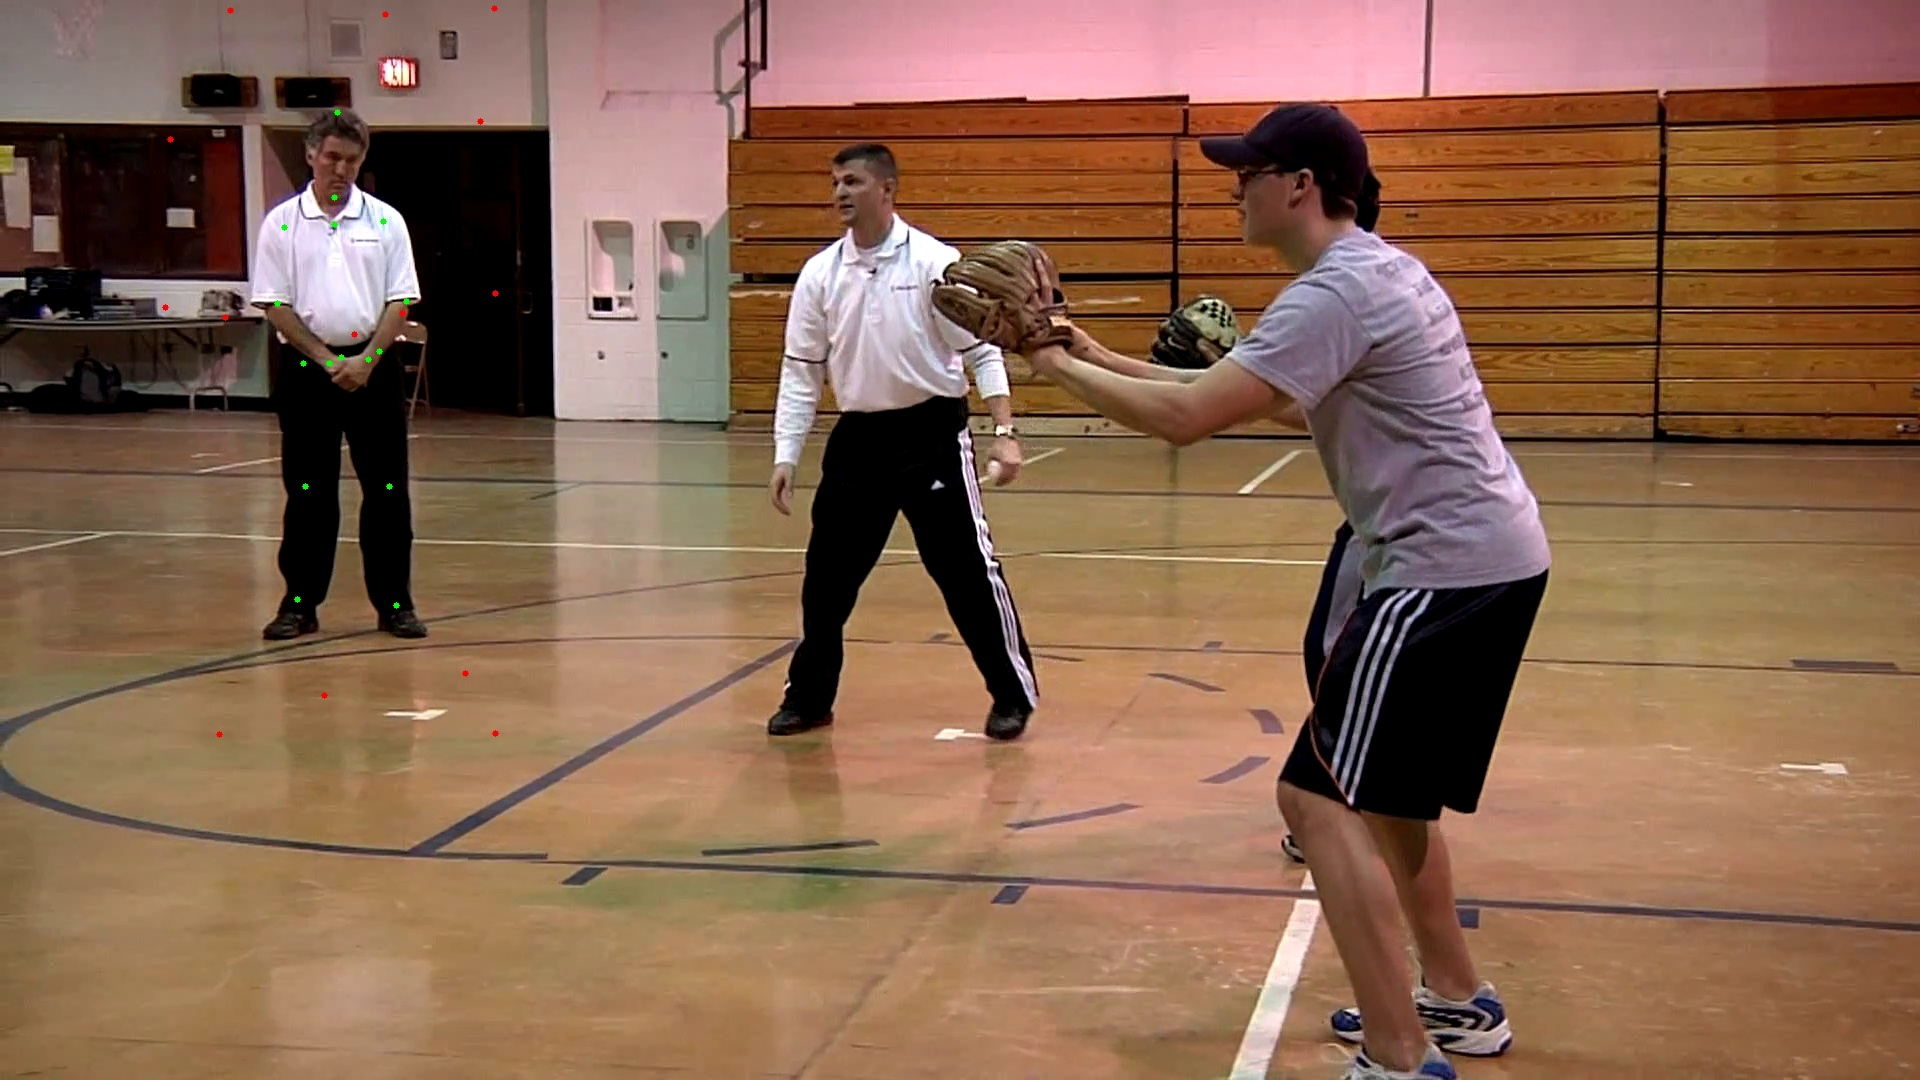

113 022879817.jpg
[738.0, 437.0]
3.519827
[[923.0, 630.0], [901.0, 532.0], [836.0, 449.0], [882.0, 415.0], [862.0, 515.0], [797.0, 605.0], [859.0, 432.0], [745.0, 274.0], [711.9408, 271.1096], [595.0592, 260.8904], [524.0, 298.0], [626.0, 288.0], [712.0, 215.0], [778.0, 332.0], [649.0, 418.0], [513.0, 407.0]]
(17, 2)
torch.Size([1, 17, 2])
PCKh:  tensor(0.)
(16, 2)


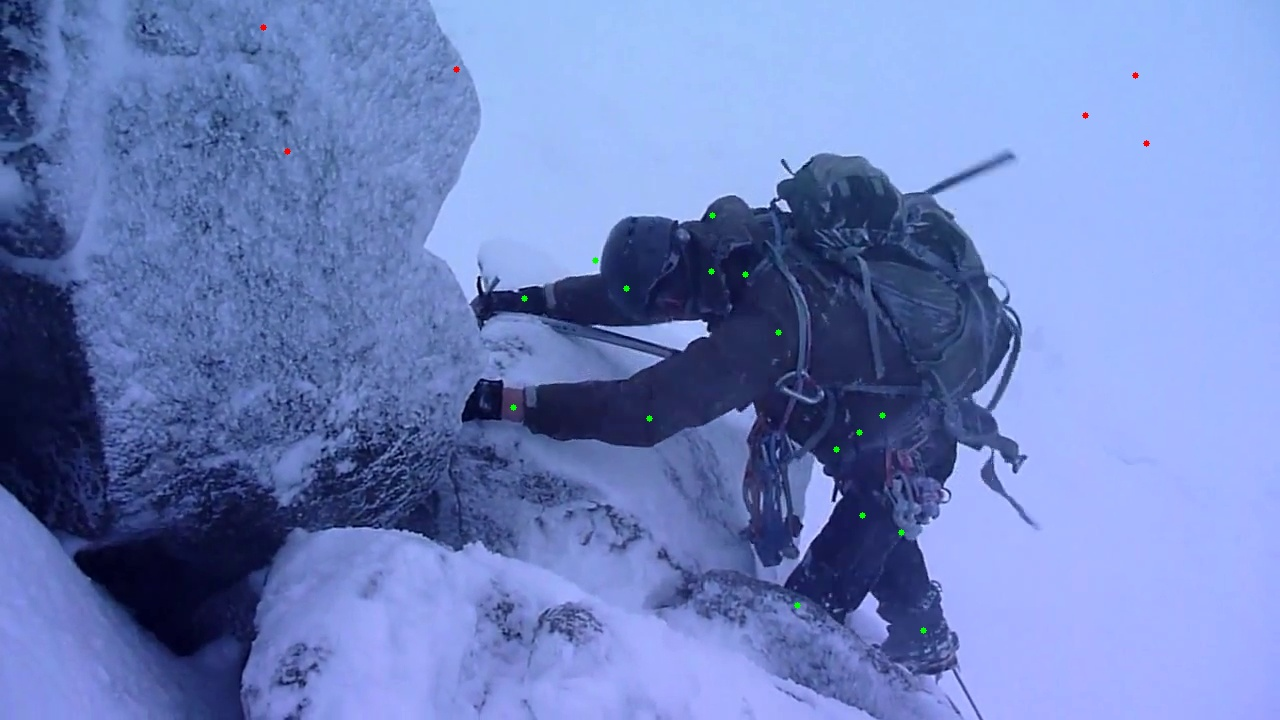

In [ ]:

ROOT_FOLDER = "/datagrid/personal/baljibil"
# ground truth
with open(ROOT_FOLDER + '/data/MPII_COCO/annotations/mpii_train.json', 'r') as f:
    annot_truth = json.load(f)
# prediction
with open(ROOT_FOLDER + '/repos/scripts/data/coco_pred_mpii.json', 'r') as f:
    annot_pred_coco = json.load(f)


NUM_IMAGES = 4

# choose image from ground truth
def choose_n_images(gt_json):
  random_numbers = np.random.randint(0, len(gt_json), size=10)
  images = list()
  for nums in random_numbers:
     images.append((nums,gt_json[nums]['image']))
  return images

for index, im_path in choose_n_images(annot_truth):
  print(index, im_path)
  # Load the image
  image = cv2.imread(ROOT_FOLDER + '/data/MPII_COCO/images/' + im_path)

  # Load annotation keypoints from JSON files

  keypoints1 = annot_truth[index]['joints']
  # pred
  print(annot_truth[index]['center'])
  print(annot_truth[index]['scale'])
  print(keypoints1)

  points = np.array(annot_pred_coco['annotations'][index]['joints'])
  points = (points - np.array(annot_truth[index]['center'])) / annot_truth[index]['scale']
  points = (points - (-150)) / (150 - (-150))
  print(points.shape)
  points = torch.tensor(points, dtype=torch.float32)
  points = points.unsqueeze(0)
  keypoints2 = None
  print(points.shape)
  best_model.eval()
  with torch.no_grad():
    points = points.to(device)
    keypoints2 = best_model(points)


  keypoints2 = keypoints2.squeeze()
  # print(np.array(annot_truth[index]['joints']))
  keypoints2 = keypoints2.to('cpu')
  keypoints2 = np.array(keypoints2)
  keypoints2 = keypoints2 * (150 - (-150)) + (-150)

  keypoints2 = annot_truth[index]['scale'] * keypoints2
  keypoints2 = keypoints2 + np.array(annot_truth[index]['center'])

  print("PCKh: ", calculatePCKh(torch.tensor(keypoints2, dtype=torch.float32).unsqueeze(0),
                                torch.tensor(annot_truth[index]['joints'], dtype=torch.float32).unsqueeze(0) ))

  print(keypoints2.shape)
  # Draw keypoints on the image
  for kp in keypoints1:
      x, y = int(kp[0]), int(kp[1])
      cv2.circle(image, (x, y), 3, (0, 255, 0), -1)

  for kp in keypoints2:
      x, y = int(kp[0]), int(kp[1])
      cv2.circle(image, (x, y), 3, (0, 0, 255), -1)

  # Resize the image if necessary
  # This step is optional, depending on your images

  # Split the image horizontally
#   image1 = image[:, :image.shape[1]//2]
#   image2 = image[:, image.shape[1]//2:]

  # Display the annotated images side by side
  cv2.imwrite(f'tm_results/image{i}.jpg', image)

  display(Image(filename=f'tm_results/image{i}.jpg'))


# Try building simple regressors

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print("Train instance: ", X_train.shape[0])
print("Val instance: ", X_val.shape[0])
print("Test instance: ", X_test.shape[0])

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)


Train instance:  7861
Val instance:  2621
Test instance:  4493
torch.Size([7861, 17, 2])
torch.Size([7861, 16, 2])
torch.Size([2621, 17, 2])
torch.Size([2621, 16, 2])


In [ ]:
from sklearn import linear_model

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

X_train_stacked = np.reshape(X_train, (X_train.shape[0], -1))
print(X_train_stacked.shape)
X_val_stacked = np.reshape(X_val, (X_val.shape[0], -1))
print(X_val_stacked.shape)
print('y_val: ', y_val.shape)

for point in range(16):
  y_train_point = y_train[:, point]
  clf_x = linear_model.LinearRegression()
  clf_y = linear_model.LinearRegression()

  clf_x.fit(X_train_stacked, y_train_point[:, 0])
  clf_y.fit(X_train_stacked, y_train_point[:, 1])

  prediction_x = clf_x.predict(X_val_stacked)
  prediction_y = clf_y.predict(X_val_stacked)

  pred = np.stack((prediction_x, prediction_y), axis=1)
  error = ((pred - y_val[:, point]) ** 2).mean(axis = 1)
  # print(error[:10])
  error = np.mean(error)
  print(f'Error {point}: {error}')

    

(7861, 34)
(2621, 34)
y_val:  (2621, 16, 2)
Error 0: 224.21932983398438
Error 1: 94.02581024169922
Error 2: 57.048316955566406
Error 3: 58.99836730957031
Error 4: 89.52011108398438
Error 5: 235.37953186035156
Error 6: 46.26677322387695
Error 7: 25.42369842529297
Error 8: 27.508214950561523
Error 9: 55.37346267700195
Error 10: 188.04627990722656
Error 11: 76.92213439941406
Error 12: 42.63243103027344
Error 13: 43.588462829589844
Error 14: 81.3226089477539
Error 15: 133.448974609375


In [ ]:
X_val = np.array(X_val)
y_val = np.array(y_val)
print(X_val.shape)
print(y_val.shape)

(2621, 17, 2)
(2621, 16, 2)


In [ ]:
print((abs(X_val[:, 16] - y_val[:, 0])).mean(axis=0))
print((abs(X_val[:, 14] - y_val[:, 1])).mean(axis=0))
# Around head location
print((abs(X_val[:, 0] - y_val[:, 9])).mean(axis=0))

# print((abs(X_val[:, 16] - y_val[:, 0])).mean(axis=0))
# print((abs(X_val[:, 16] - y_val[:, 0])).mean(axis=0))
# print((abs(X_val[:, 16] - y_val[:, 0])).mean(axis=0))


[5.7771764 6.6435676]
[4.1824436 5.1991277]
[ 6.9651403 18.852098 ]
